<a href="https://colab.research.google.com/github/avladova/MLSD/blob/main/MLSD2024_D_Hoeffding_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://habr.com/ru/articles/311092/
#https://fitter.readthedocs.io/en/latest/references.html
#https://habr.com/ru/articles/575116/
#https://tinyheero.github.io/2016/01/03/gmm-em.html
#https://habr.com/ru/articles/527334/

# Загрузка

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from sklearn import preprocessing
#%pylab inline

In [24]:
ID='1JweHYY03X9p8mU4TkMJhI6MUiqZziKMJaTqexgLawNc'
sheet_url="https://docs.google.com/spreadsheets/d/1JweHYY03X9p8mU4TkMJhI6MUiqZziKMJaTqexgLawNc/edit#gid=1744952440"
url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
raw=pd.read_csv(url_1)
raw.rename(columns={'Depth of the sole layer, m':'Depth, m','Power, m':'Thickness, m', 'Code':'Code of soil', 'Description':'Soil description'}, inplace=True)
print(raw.info())
raw.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   km                593 non-null    int64  
 1   Picket            593 non-null    int64  
 2   Rider, m          593 non-null    float64
 3   Depth, m          593 non-null    float64
 4   Thickness, m      593 non-null    float64
 5   Code of soil      593 non-null    int64  
 6   Soil description  591 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 32.6+ KB
None


,km,Picket,"Rider, m","Depth, m","Thickness, m",Code of soil,Soil description
69,341,3418,57.0,0.7,0.7,913,Торф 1 типа сильноразложившийся
90,342,3422,57.0,3.5,3.0,209,Суглинок пластичномерзлый
312,346,3469,95.1,3.9,1.4,445,Песок мелкий средней степени водонасыщения
260,346,3460,38.8,5.9,2.9,446,Песок мелкий насыщенный водой
459,350,3502,82.6,2.2,2.2,919,Торф слаборазложившийся пластичномерзлый


## Корреляции

In [25]:
raw.drop(columns=['km','Rider, m', 'Soil description']).corr()

,Picket,"Depth, m","Thickness, m",Code of soil
Picket,1.000000,-0.030614,-0.073708,-0.255911
"Depth, m",-0.030614,1.000000,0.469286,-0.220055
"Thickness, m",-0.073708,0.469286,1.000000,-0.020978
Code of soil,-0.255911,-0.220055,-0.020978,1.000000


In [26]:
raw.drop(columns=['km','Rider, m', 'Soil description']).corr(method='spearman')

,Picket,"Depth, m","Thickness, m",Code of soil
Picket,1.000000,-0.052822,-0.107634,-0.361035
"Depth, m",-0.052822,1.000000,0.563769,0.061301
"Thickness, m",-0.107634,0.563769,1.000000,0.156892
Code of soil,-0.361035,0.061301,0.156892,1.000000


In [27]:
raw.drop(columns=['km','Rider, m', 'Soil description']).corr(method='kendall')

,Picket,"Depth, m","Thickness, m",Code of soil
Picket,1.000000,-0.035586,-0.073730,-0.246784
"Depth, m",-0.035586,1.000000,0.439135,0.049050
"Thickness, m",-0.073730,0.439135,1.000000,0.115211
Code of soil,-0.246784,0.049050,0.115211,1.000000


In [28]:
df=raw.copy()
df['Distance, m']=df['Picket']+df['Rider, m']*0.01
df.describe()

,km,Picket,"Rider, m","Depth, m","Thickness, m",Code of soil,"Distance, m"
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,346.504216,3469.895447,52.656627,6.377909,2.259865,375.873524,3470.422013
std,4.461214,44.746461,25.219520,4.861157,1.964020,249.829913,44.742484
min,340.000000,3403.000000,0.000000,0.000000,0.000000,0.000000,3403.570000
25%,343.000000,3434.000000,40.000000,1.900000,0.900000,205.000000,3434.640000
50%,346.000000,3466.000000,56.000000,5.000000,1.700000,307.000000,3466.443000
75%,349.000000,3497.000000,66.000000,11.200000,2.900000,448.000000,3497.100000
max,358.000000,3589.000000,96.000000,17.000000,10.500000,931.000000,3589.400000


In [29]:
df.dropna(inplace=True)
df = df.astype({'Code of soil':'int'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 592
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   km                591 non-null    int64  
 1   Picket            591 non-null    int64  
 2   Rider, m          591 non-null    float64
 3   Depth, m          591 non-null    float64
 4   Thickness, m      591 non-null    float64
 5   Code of soil      591 non-null    int64  
 6   Soil description  591 non-null    object 
 7   Distance, m       591 non-null    float64
dtypes: float64(4), int64(3), object(1)
memory usage: 41.6+ KB


# Нелинейная корреляция Hoeffding

## Неравномерная сетка

<Figure size 4500x800 with 0 Axes>

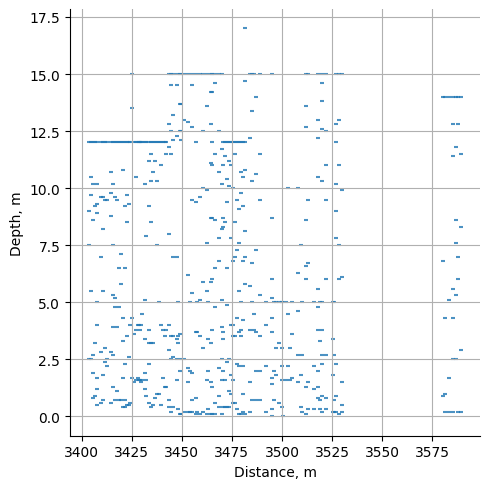

In [34]:
# Plot the grid based on the Distance and Depth of the sole layer
plt.figure(figsize=(45, 8))
sns.lmplot(x='Distance, m', y='Depth, m', data=df, fit_reg=False, scatter_kws={"s": 10}, markers="_")
plt.show()

In [31]:
dtfr=df.copy().set_index(['Distance, m','Depth, m'])
dtfr[['Thickness, m', 'Code of soil']]
dtfr[['Thickness, m', 'Code of soil']].corr(method='spearman')

,"Thickness, m",Code of soil
"Thickness, m",1.000000,0.148284
Code of soil,0.148284,1.000000


In [32]:
data=dtfr[['Thickness, m', 'Code of soil']].dropna()
# Вычисление статистической меры D Хёфдинга
def d_hellinger(u, v):
    return np.sqrt(1 - np.exp(-0.25 * np.sum((np.sqrt(u) - np.sqrt(v))**2)))

# Вычисление матрицы расстояний с использованием статистической меры D Хёфдинга
distances = cdist(data.values,data.values, metric=d_hellinger)

<Axes: >

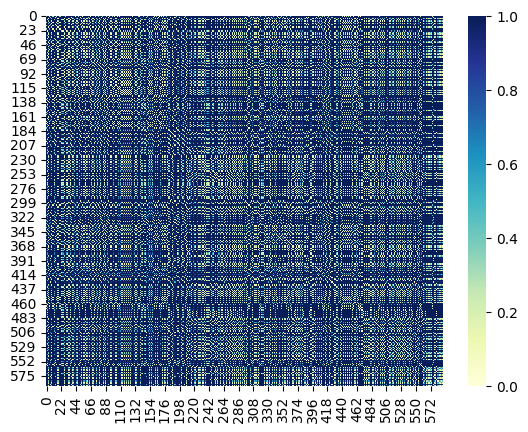

In [33]:
sns.heatmap(distances, cmap="YlGnBu")